In [858]:
import pandas as pd
import numpy as np
import seaborn as sns


In [859]:
houses_train = pd.read_csv('../data/processed_data.csv',keep_default_na=False)
#houses_test = pd.read_csv('../data/cleaned_test_data.csv',keep_default_na=False)

In [860]:
houses_train.head()

,MSSubClass,LotFrontage,LotArea,Street,Utilities,YearBuilt,YearRemodAdd,MasVnrArea,BsmtExposure,BsmtUnfSF,...,Exter_Rating,Bsmt_rating,Basement_bathrooms,Aboveground_bathrooms,Kitchen_Rating,Fireplace_Rating,Total_Condtion,BsmtFinType1_rating,BsmtFinType2_rating,Bsmt_total_SF_rating
0,60,0.150685,0.033420,1.0,1.0,0.949275,0.883333,0.12250,0.25,0.064212,...,1.166667,1.55,0.333333,0.916667,0.222222,0.000000,2.0,0.125089,0.0,0.125089
1,20,0.202055,0.038795,1.0,1.0,0.753623,0.433333,0.00000,1.00,0.121575,...,0.833333,1.55,0.250000,0.666667,0.111111,0.200000,2.0,0.144401,0.0,0.144401
2,60,0.160959,0.046507,1.0,1.0,0.934783,0.866667,0.10125,0.50,0.185788,...,1.166667,1.55,0.333333,0.916667,0.222222,0.200000,2.0,0.086109,0.0,0.086109
3,70,0.133562,0.038561,1.0,1.0,0.311594,0.333333,0.00000,0.25,0.231164,...,0.833333,1.60,0.333333,0.333333,0.222222,0.266667,2.0,0.031892,0.0,0.031892
4,60,0.215753,0.060576,1.0,1.0,0.927536,0.833333,0.21875,0.75,0.209760,...,1.166667,1.55,0.333333,0.916667,0.222222,0.200000,2.0,0.116052,0.0,0.116052


In [861]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [862]:
X = houses_train.drop(['SalePrice'],axis=1)
y = np.log10(houses_train['SalePrice'])

In [863]:
X_train, X_val, y_train, y_val = train_test_split(X.copy(), y.copy(),
                                                                 shuffle = True,
                                                                 random_state = 321,
                                                                 test_size=.25)

exp_y_val = np.exp(y_val)

In [864]:
number_of_models = 5
model_dict = {}
metrics = ['log_mse', 'r2_score','mse']


In [865]:
model = RandomForestRegressor(n_estimators=100, random_state=0)
model.fit(X_train,y_train)
A = model.predict(X_val)

display(mean_squared_error(y_val,A))
display(r2_score(y_val,A))
model_dict['Random_forest'] = [mean_squared_error(y_val,A),r2_score(y_val,A),mean_squared_error(exp_y_val,np.exp(A))]

0.0035728399395999412

0.8677733128555142

In [866]:
import xgboost

xgb_reg = xgboost.XGBRegressor(n_estimators=150,
                          max_depth=3,
                          learning_rate=.1)


xgb_reg.fit(X_train, y_train)

B = xgb_reg.predict(X_val)

display(mean_squared_error(y_val,B))
display(r2_score(y_val,B))
model_dict['XGBoost'] = [mean_squared_error(y_val,B),r2_score(y_val,B),mean_squared_error(exp_y_val,np.exp(B))]

0.003353109694568571

0.8759052759037098

<Axes: >

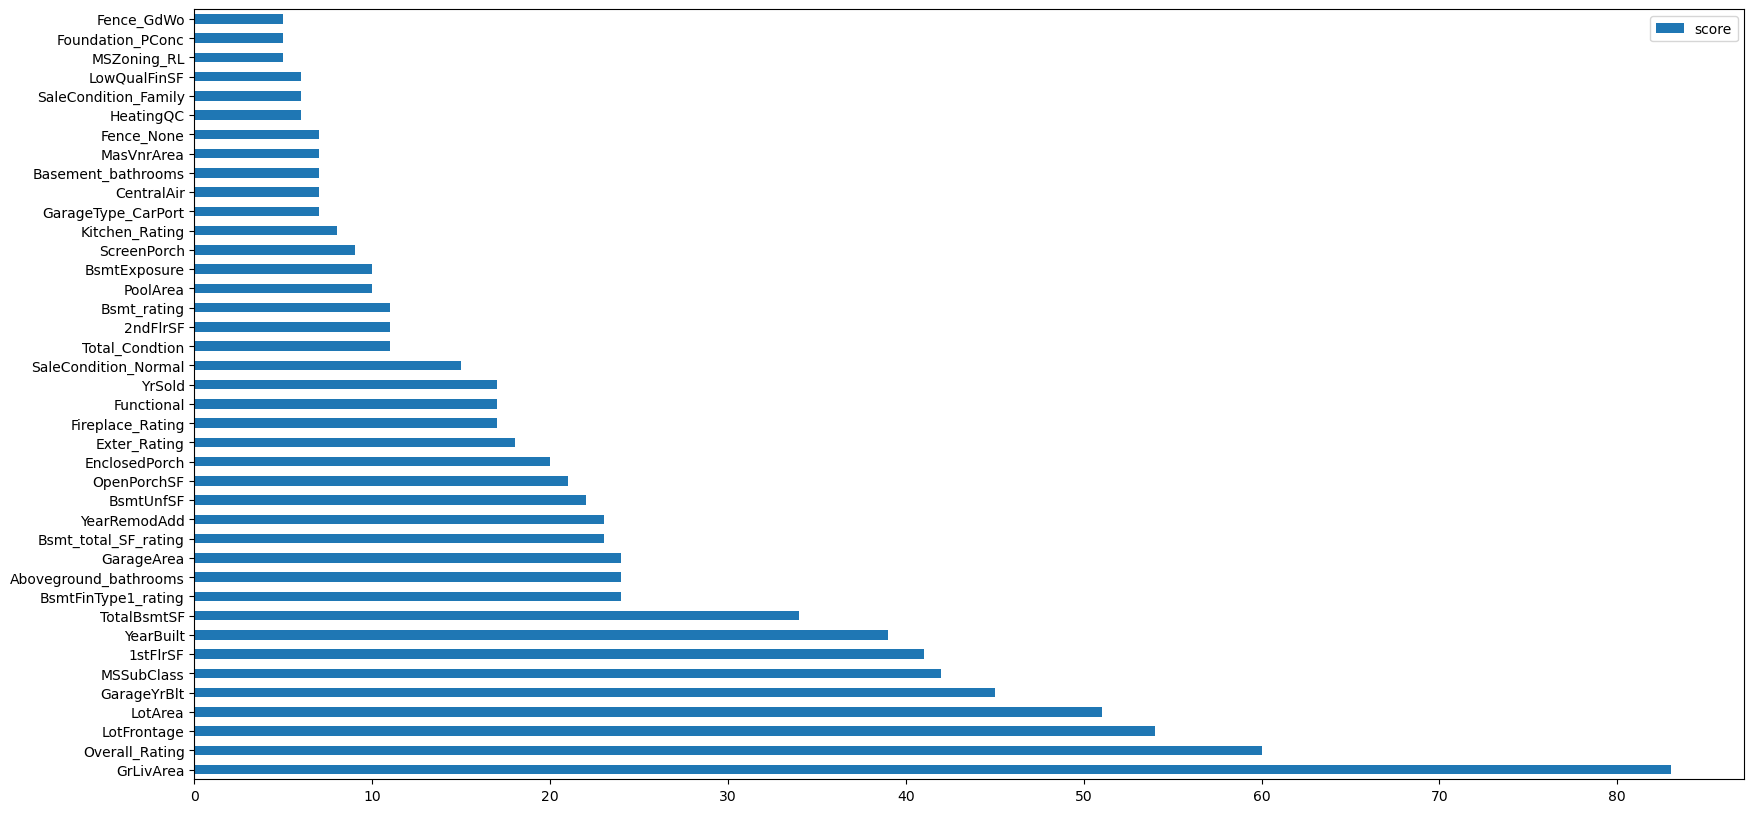

In [867]:
dic = xgb_reg.get_booster().get_score(importance_type='weight')
keys = list(dic.keys())
values = list(dic.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(40, columns="score").plot(kind='barh', figsize = (20,10)) ## plot top 40 features




In [868]:
n = 50
for i in range(1,n+1):
    features_for_reducedmodel = list(data.index[:i]) 
    X_train_red = X_train[features_for_reducedmodel]
    X_val_red = X_val[features_for_reducedmodel]
    lm.fit(X_train_red,y_train)
    E = lm.predict(X_val_red)
    model_dict['OLS_reduced_'+str(i)] = [mean_squared_error(y_val,E),r2_score(y_val,E),mean_squared_error(exp_y_val,np.exp(E))]

In [869]:
from sklearn.linear_model import LinearRegression

lm = LinearRegression()

lm.fit(X_train,y_train)

C= lm.predict(X_val)

display(mean_squared_error(y_val,C))
display(r2_score(y_val,C))
model_dict['OLS'] = [mean_squared_error(y_val,C),r2_score(y_val,C),mean_squared_error(exp_y_val,np.exp(C))]

0.004212802187763748

0.8440890478442715

In [870]:
from sklearn.linear_model import Lasso 

lasso_lm = Lasso(alpha=.01)

lasso_lm.fit(X_train,y_train)

D= lasso_lm.predict(X_val)

display(mean_squared_error(y_val,D))
display(r2_score(y_val,D))
model_dict['Lasso'] = [mean_squared_error(y_val,D),r2_score(y_val,D),mean_squared_error(exp_y_val,np.exp(D))]

0.008996185450822444

0.6670615478977016

In [871]:
keys = list(model_dict.keys())
values = list(model_dict.values())

performance = pd.DataFrame(data=values, index=keys, columns=metrics)

In [872]:
performance

,log_mse,r2_score,mse
Random_forest,0.003573,0.867773,145.908360
XGBoost,0.003353,0.875905,145.054367
OLS_reduced_1,0.014243,0.472885,580.570433
OLS_reduced_2,0.010876,0.597478,469.108402
OLS_reduced_3,0.010606,0.607470,462.564457
OLS_reduced_4,0.010576,0.608602,464.856772
OLS_reduced_5,0.006729,0.750952,303.525720
OLS_reduced_6,0.006804,0.748198,303.622234
OLS_reduced_7,0.006360,0.764635,295.604980
OLS_reduced_8,0.005364,0.801470,252.019151
